In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# HLC = 300

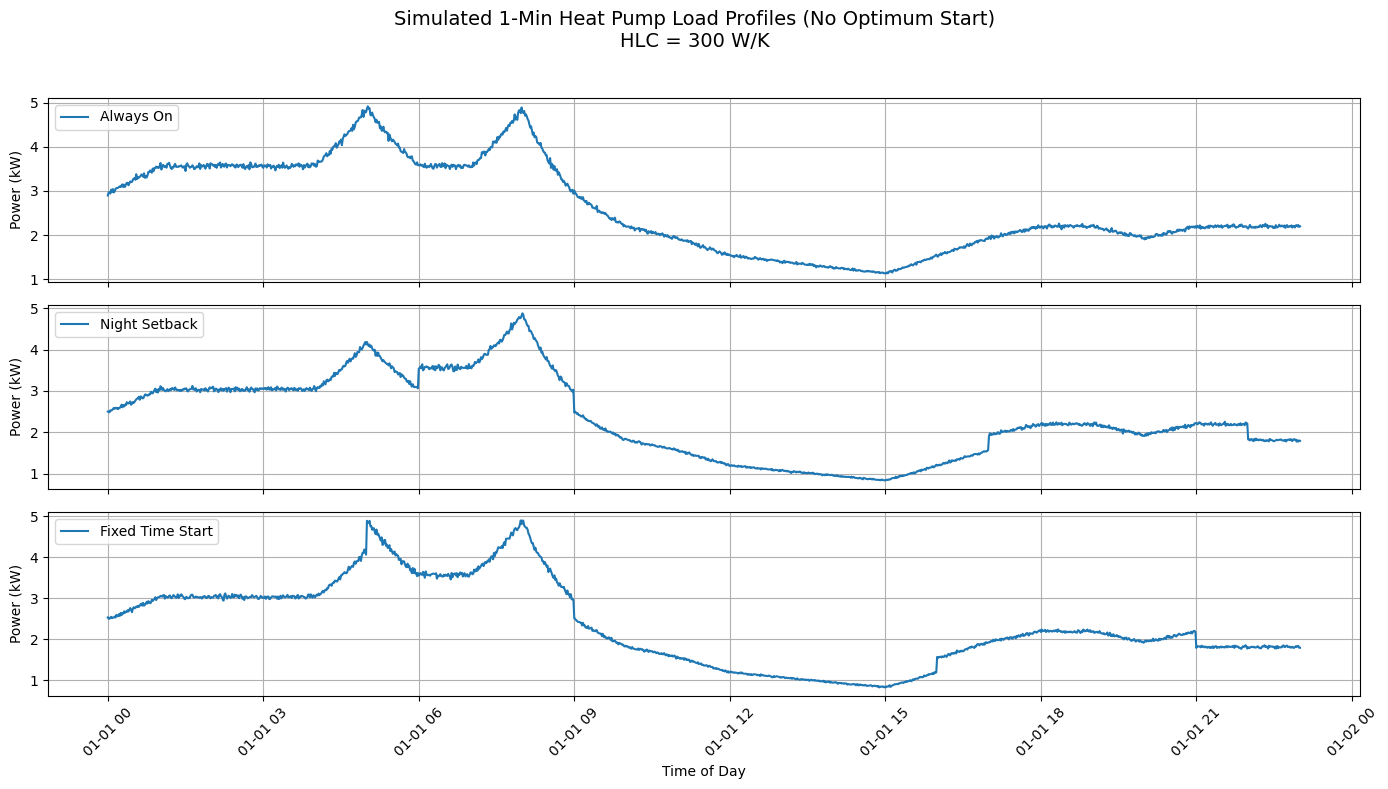

In [2]:
# Input parameters

# Hourly outdoor temperature and COP values (24 each)
hourly_temp = np.array([
    -5, -6, -6, -6, -6, -7, -6, -6, -7, -5, -2, 0,
     3,  4,  5,  6,  3,  0, -2, -2,  0, -2, -2, -2
])
hourly_COP = np.array([
    2.64, 2.27, 2.27, 2.27, 2.27, 1.72, 2.27, 2.27,
    1.72, 2.64, 3.14, 3.26, 3.5, 3.64, 3.79, 3.96,
    3.5, 3.26, 3.14, 3.14, 3.26, 3.14, 3.14, 3.14
])

# Constants
indoor_temp_main = 21     # Comfort setpoint
indoor_temp_setback = 17  # Night setback temperature
HLC = 300                 # Heat Loss Coefficient [W/K]
time_step = 60            # Seconds per timestep

# Creating 1-min dataframe

minute_idx = pd.date_range("1900-01-01", periods=1440, freq='1min')
df = pd.DataFrame(index=minute_idx)

hourly_idx = pd.date_range("1900-01-01", periods=24, freq='h')
df['outdoor_temp'] = pd.Series(hourly_temp, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)
df['COP'] = pd.Series(hourly_COP, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)

# Defining active periods

def get_active_mask(hours):
    return df.index.hour.isin(hours)

scenarios = {
    'always_on': list(range(24)),
    'night_setback': list(range(6, 9)) + list(range(17, 22)),
    'fixed_time_start': list(range(5, 9)) + list(range(16, 21))
}

# Simulation

results_300 = pd.DataFrame(index=df.index)

for name, active_hours in scenarios.items():
    df_temp = df.copy()
    df_temp['active'] = get_active_mask(active_hours)
    df_temp['group'] = (df_temp['active'] != df_temp['active'].shift()).cumsum()

    # Set indoor temperature: main during active, setback otherwise
    df_temp['T_indoor'] = np.where(df_temp['active'], indoor_temp_main, indoor_temp_setback)

    # Heat demand
    df_temp['delta_T'] = df_temp['T_indoor'] - df_temp['outdoor_temp']
    df_temp['Q_loss_W'] = df_temp['delta_T'] * HLC
    df_temp['Q_kWh'] = (df_temp['Q_loss_W'] * time_step) / 3600000  # W·s = kWh

    # Add small randomness (±1%) to reflect natural variation
    df_temp['weight'] = 1.0 + np.random.normal(0.0, 0.01, len(df_temp))
    df_temp['Q_kWh_weighted'] = df_temp['Q_kWh'] * df_temp['weight']

    # Electrical power
    df_temp['elec_kWh'] = df_temp['Q_kWh_weighted'] / df_temp['COP']
    df_temp['kW'] = df_temp['elec_kWh'] * 60  # Convert to kW

    # Save result
    results_300[name] = df_temp['kW']

# Plot

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)
for ax, name in zip(axs, scenarios.keys()):
    ax.plot(results_300.index, results_300[name], label=name.replace("_", " ").title())
    ax.set_ylabel("Power (kW)")
    ax.legend(loc='upper left')
    ax.grid(True)

axs[-1].set_xlabel("Time of Day")
fig.suptitle(f"Simulated 1-Min Heat Pump Load Profiles (No Optimum Start)\nHLC = {HLC} W/K", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [3]:
daily_energy_kWh = results_300.sum() / 60  # Sum over all minutes, then dividing by 60 to get kWh
print(daily_energy_kWh)


always_on           60.021915
night_setback       53.556002
fixed_time_start    54.156602
dtype: float64


# HLC = 200

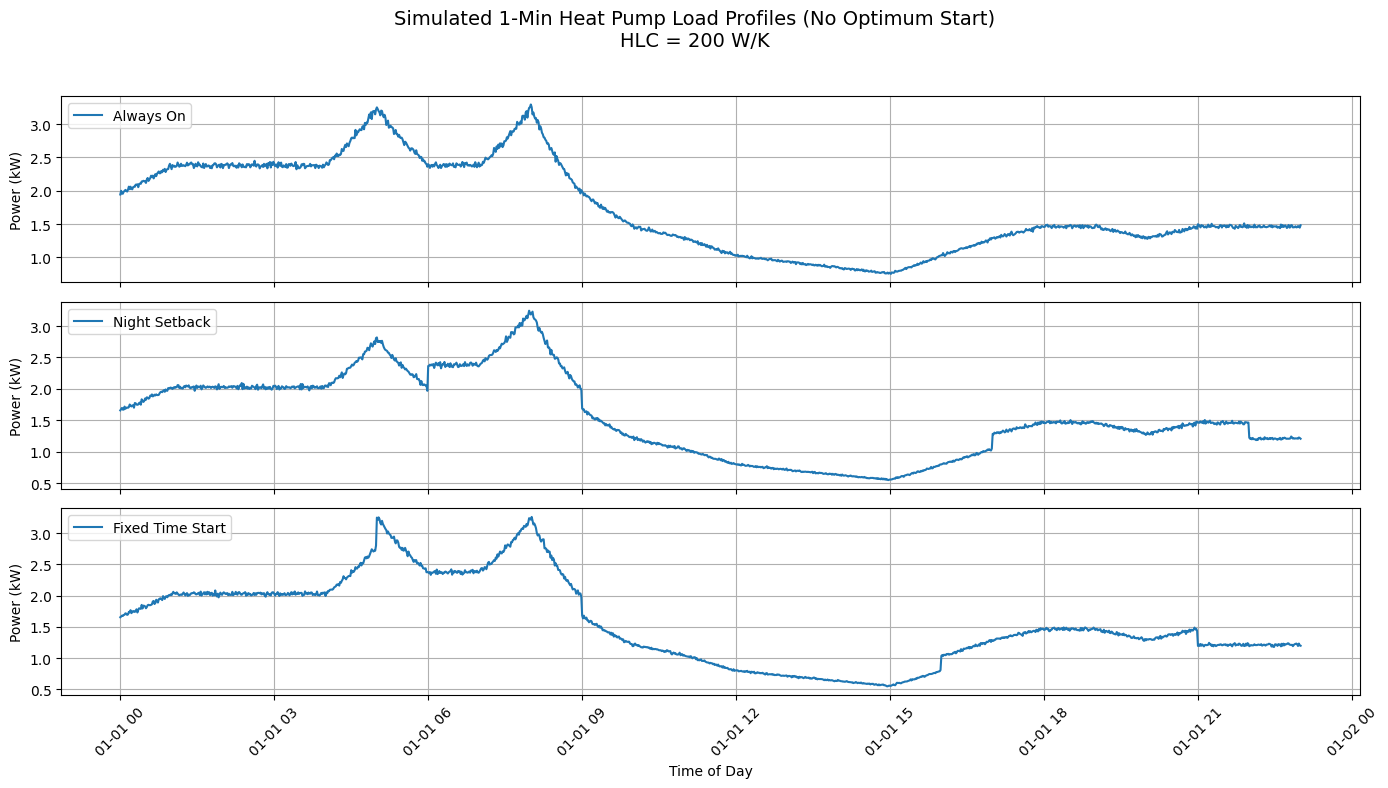

In [4]:
# Input parameters

# Hourly outdoor temperature and COP values (24 each)
hourly_temp = np.array([
    -5, -6, -6, -6, -6, -7, -6, -6, -7, -5, -2, 0,
     3,  4,  5,  6,  3,  0, -2, -2,  0, -2, -2, -2
])
hourly_COP = np.array([
    2.64, 2.27, 2.27, 2.27, 2.27, 1.72, 2.27, 2.27,
    1.72, 2.64, 3.14, 3.26, 3.5, 3.64, 3.79, 3.96,
    3.5, 3.26, 3.14, 3.14, 3.26, 3.14, 3.14, 3.14
])

# Constants
indoor_temp_main = 21     # Comfort setpoint
indoor_temp_setback = 17  # Night setback temperature
HLC = 200                 # Heat Loss Coefficient [W/K]
time_step = 60            # Seconds per timestep

# Creating 1-min dataframe

minute_idx = pd.date_range("1900-01-01", periods=1440, freq='1min')
df = pd.DataFrame(index=minute_idx)

hourly_idx = pd.date_range("1900-01-01", periods=24, freq='h')
df['outdoor_temp'] = pd.Series(hourly_temp, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)
df['COP'] = pd.Series(hourly_COP, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)

# Defining active periods

def get_active_mask(hours):
    return df.index.hour.isin(hours)

scenarios = {
    'always_on': list(range(24)),
    'night_setback': list(range(6, 9)) + list(range(17, 22)),
    'fixed_time_start': list(range(5, 9)) + list(range(16, 21))
}

# Simulation

results_200 = pd.DataFrame(index=df.index)

for name, active_hours in scenarios.items():
    df_temp = df.copy()
    df_temp['active'] = get_active_mask(active_hours)
    df_temp['group'] = (df_temp['active'] != df_temp['active'].shift()).cumsum()

    # Set indoor temperature: main during active, setback otherwise
    df_temp['T_indoor'] = np.where(df_temp['active'], indoor_temp_main, indoor_temp_setback)

    # Heat demand
    df_temp['delta_T'] = df_temp['T_indoor'] - df_temp['outdoor_temp']
    df_temp['Q_loss_W'] = df_temp['delta_T'] * HLC
    df_temp['Q_kWh'] = (df_temp['Q_loss_W'] * time_step) / 3600000  # W·s = kWh

    # Add small randomness (±1%) to reflect natural variation
    df_temp['weight'] = 1.0 + np.random.normal(0.0, 0.01, len(df_temp))
    df_temp['Q_kWh_weighted'] = df_temp['Q_kWh'] * df_temp['weight']

    # Electrical power
    df_temp['elec_kWh'] = df_temp['Q_kWh_weighted'] / df_temp['COP']
    df_temp['kW'] = df_temp['elec_kWh'] * 60  # Convert to kW

    # Save result
    results_200[name] = df_temp['kW']

# Plot

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)
for ax, name in zip(axs, scenarios.keys()):
    ax.plot(results_200.index, results_200[name], label=name.replace("_", " ").title())
    ax.set_ylabel("Power (kW)")
    ax.legend(loc='upper left')
    ax.grid(True)

axs[-1].set_xlabel("Time of Day")
fig.suptitle(f"Simulated 1-Min Heat Pump Load Profiles (No Optimum Start)\nHLC = {HLC} W/K", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [5]:
daily_energy_kWh = results_200.sum() / 60  # Sum over all minutes, then dividing by 60 to get kWh
print(daily_energy_kWh)


always_on           40.038338
night_setback       35.717833
fixed_time_start    36.108120
dtype: float64


# HLC = 100

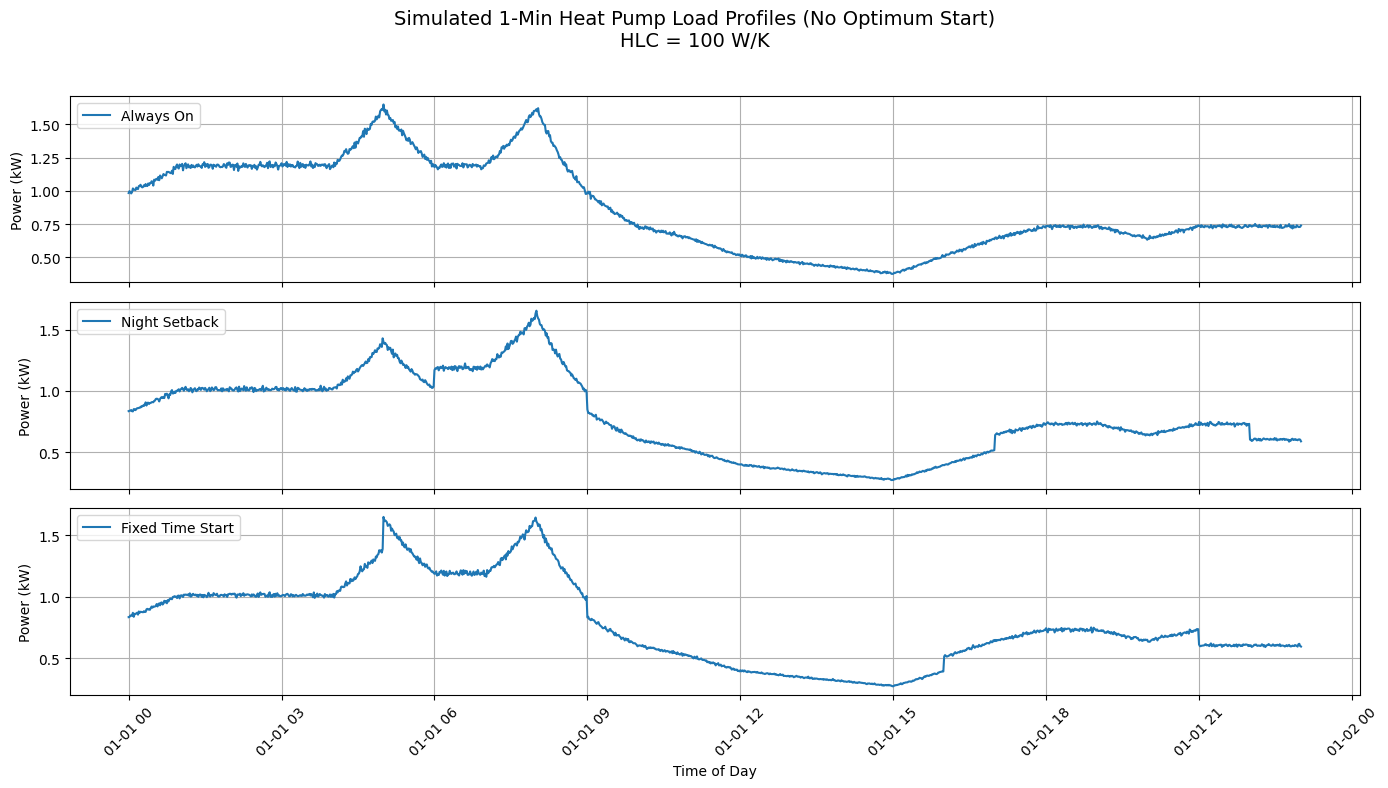

In [6]:
# Input parameters

# Hourly outdoor temperature and COP values (24 each)
hourly_temp = np.array([
    -5, -6, -6, -6, -6, -7, -6, -6, -7, -5, -2, 0,
     3,  4,  5,  6,  3,  0, -2, -2,  0, -2, -2, -2
])
hourly_COP = np.array([
    2.64, 2.27, 2.27, 2.27, 2.27, 1.72, 2.27, 2.27,
    1.72, 2.64, 3.14, 3.26, 3.5, 3.64, 3.79, 3.96,
    3.5, 3.26, 3.14, 3.14, 3.26, 3.14, 3.14, 3.14
])

# Constants
indoor_temp_main = 21     # Comfort setpoint
indoor_temp_setback = 17  # Night setback temperature
HLC = 100                 # Heat Loss Coefficient [W/K]
time_step = 60            # Seconds per timestep

# Creating 1-min dataframe

minute_idx = pd.date_range("1900-01-01", periods=1440, freq='1min')
df = pd.DataFrame(index=minute_idx)

hourly_idx = pd.date_range("1900-01-01", periods=24, freq='h')
df['outdoor_temp'] = pd.Series(hourly_temp, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)
df['COP'] = pd.Series(hourly_COP, index=hourly_idx).resample('1min').interpolate('linear').reindex(df.index)

# Defining active periods

def get_active_mask(hours):
    return df.index.hour.isin(hours)

scenarios = {
    'always_on': list(range(24)),
    'night_setback': list(range(6, 9)) + list(range(17, 22)),
    'fixed_time_start': list(range(5, 9)) + list(range(16, 21))
}

# Simulation

results_100 = pd.DataFrame(index=df.index)

for name, active_hours in scenarios.items():
    df_temp = df.copy()
    df_temp['active'] = get_active_mask(active_hours)
    df_temp['group'] = (df_temp['active'] != df_temp['active'].shift()).cumsum()

    # Set indoor temperature: main during active, setback otherwise
    df_temp['T_indoor'] = np.where(df_temp['active'], indoor_temp_main, indoor_temp_setback)

    # Heat demand
    df_temp['delta_T'] = df_temp['T_indoor'] - df_temp['outdoor_temp']
    df_temp['Q_loss_W'] = df_temp['delta_T'] * HLC
    df_temp['Q_kWh'] = (df_temp['Q_loss_W'] * time_step) / 3600000  # W·s = kWh

    # Add small randomness (±1%) to reflect natural variation
    df_temp['weight'] = 1.0 + np.random.normal(0.0, 0.01, len(df_temp))
    df_temp['Q_kWh_weighted'] = df_temp['Q_kWh'] * df_temp['weight']

    # Electrical power
    df_temp['elec_kWh'] = df_temp['Q_kWh_weighted'] / df_temp['COP']
    df_temp['kW'] = df_temp['elec_kWh'] * 60  # Convert to kW

    # Save result
    results_100[name] = df_temp['kW']

# Plot

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)
for ax, name in zip(axs, scenarios.keys()):
    ax.plot(results_100.index, results_100[name], label=name.replace("_", " ").title())
    ax.set_ylabel("Power (kW)")
    ax.legend(loc='upper left')
    ax.grid(True)

axs[-1].set_xlabel("Time of Day")
fig.suptitle(f"Simulated 1-Min Heat Pump Load Profiles (No Optimum Start)\nHLC = {HLC} W/K", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
daily_energy_kWh = results_100.sum() / 60  # Sum over all minutes, then dividing by 60 to get kWh
print(daily_energy_kWh)


always_on           20.013062
night_setback       17.852865
fixed_time_start    18.052192
dtype: float64


In [8]:
results_100.head()

,always_on,night_setback,fixed_time_start
1900-01-01 00:00:00,0.984404,0.836009,0.834619
1900-01-01 00:01:00,0.998510,0.839212,0.836459
1900-01-01 00:02:00,0.991590,0.840185,0.848591
1900-01-01 00:03:00,0.981215,0.844980,0.846295
1900-01-01 00:04:00,0.991337,0.834718,0.846930


In [9]:
results_300.to_csv('HP_load_poor.csv')
results_200.to_csv('HP_load_average.csv')
results_100.to_csv('HP_load_good.csv')